In [150]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from glob import glob

import pandas as pd
import plotnine as p
from tqdm import tqdm
import anndata

from scipy import stats
import matplotlib.colors as mcolors

import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


C:\Users\vale\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
slideseq = anndata.read('../../Research Projects/Ongoing/Huwe/Data/Slide-seq/slide_seq_sagittal_hippocampus.h5ad')

In [5]:
slideseqv2 = anndata.read('stickels_et_al_2020_slide_seqV2.h5ad')

In [8]:
mask = slideseqv2.obs['tissue'].str.contains('hipp')
slideseqv2_hippocampus = slideseqv2[mask].copy()

In [9]:
slideseqv2_hippocampus.obs['total_counts'] = np.array(slideseqv2_hippocampus.X.sum(1))[:, 0]
slideseqv2_hippocampus.obs['detected_genes'] = np.array((slideseqv2_hippocampus.X > 0).sum(1))[:, 0]

In [10]:
slideseq.obs['total_counts'] = np.array(slideseq.X.sum(1))[:, 0]
slideseq.obs['detected_genes'] = np.array((slideseq.X > 0).sum(1))[:, 0]

In [18]:
slideseq.obs = slideseq.obs.assign(filename=lambda d: d['puck_file'])

In [23]:
data = slideseq.concatenate(slideseqv2_hippocampus, batch_key='protocol', batch_categories=['Slide-seq', 'Slide-seqV2'])

In [56]:
def make_kde(x1, x2):
    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f

In [119]:
sub_data = (
    data.obs
    .groupby('protocol')
    .apply(lambda d: d.sample(10000))
    .drop('protocol', 1)
    .reset_index()
    .set_index('level_1')
)

In [127]:
smf.ols('log(total_counts) ~ protocol', sub_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log(total_counts)   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     9029.
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        17:50:49   Log-Likelihood:                -31984.
No. Observations:               20000   AIC:                         6.397e+04
Df Residuals:                   19998   BIC:                         6.399e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.7609      0.012    314.037      0.000       3.737       3.784
protocol[T.Slide-seqV2]     1.6093      0.017     95.019      0.000       1.576       1.642
==============================================================================
Omnibus:                       78.757   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.156
Skew:                           0.121   Prob(JB):                     7.89e-17
Kurtosis:                       2.825   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
np.exp(3.7)

40.4473043600674

In [128]:
np.exp(1.6)

4.953032424395115

In [130]:
np.exp(3.7 + 1.6)

200.33680997479183

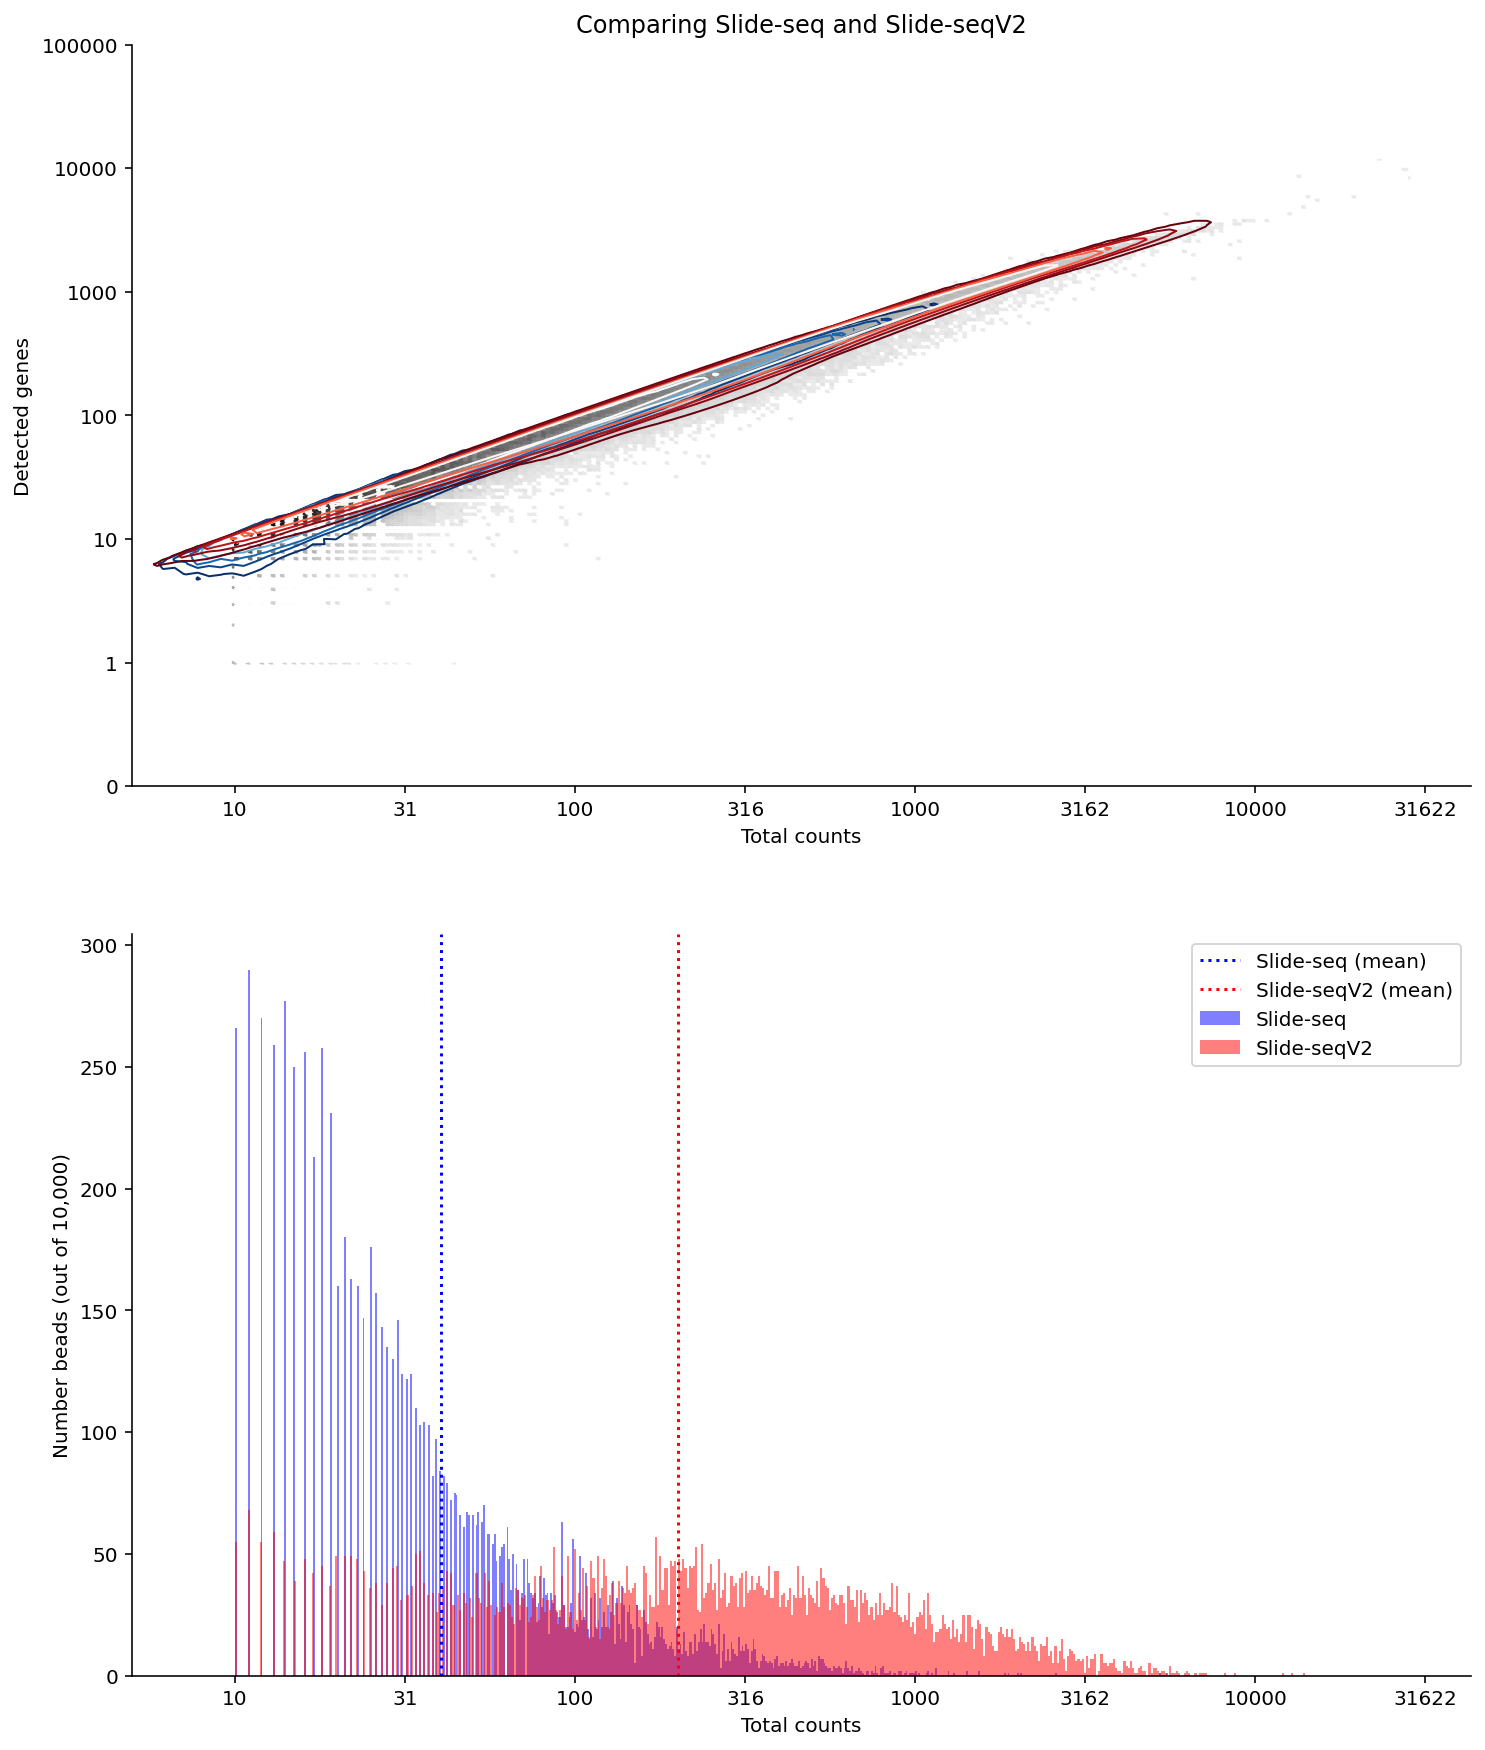

In [161]:
figsize(12, 15)

plt.subplot(2, 1, 1)

plt.hexbin(
    np.log10(data.obs['total_counts']),
    np.log10(data.obs['detected_genes']),
    gridsize=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=cm.gray_r,
    rasterized=True
);


colors = iter([cm.Blues_r, cm.Reds_r])
for p_, grp_ in data.obs.groupby('protocol'):
    X = grp_[['total_counts', 'detected_genes']].sample(10000)
    color='r'
    xx1, xx2, f = make_kde(
        np.log10(X['total_counts']),
        np.log10(X['detected_genes'])
    )

    ax = plt.gca()
    cset = ax.contour(
        xx1,
        xx2,
        f,
        levels=np.array([0.1, 0.25, 0.5, 1.0, 2.0]),
        cmap=next(colors),
        linewidths=1.
    )

locs, labs = plt.xticks()
plt.xticks(locs, [int(10 ** i) for i in locs])

locs, labs = plt.yticks()
plt.yticks(locs, [int(10 ** i) for i in locs])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Total counts')
plt.ylabel('Detected genes')

plt.title('Comparing Slide-seq and Slide-seqV2')

# ------------------------------------------------

plt.subplot(2, 1, 2, sharex=ax)

colors = iter(['b', 'r'])
for p_, grp_ in data.obs.groupby('protocol'):
    plt.hist(
        np.log10(grp_['total_counts']).sample(10000),
        bins=512,
        alpha=0.5,
        fc=next(colors),
        label=p_
    );
    
ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Total counts')
plt.ylabel('Number beads (out of 10,000)');

plt.axvline(
    np.log10(np.exp(3.7)),
    color='b',
    linestyle=':',
    label='Slide-seq (mean)'
);
plt.axvline(
    np.log10(np.exp(3.7 + 1.6)),
    color='r',
    linestyle=':',
    label='Slide-seqV2 (mean)'
);

plt.legend();

plt.savefig('comparison_plot.png', dpi=300)